# LOFAR station imaging


The aim of this notebook is to create an image from actual LOFAR data recorded with station CS501 in LBA_OUTER configuration: the outermost 48 Low Band Antennas.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
import os
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt
from lofarantpos.db import LofarAntennaDatabase

def hdfig(subplots_def=None, scale=0.5, figsize=(8, 4.5)):
    fig = plt.figure(figsize=figsize, dpi=scale*1920/8)
    if subplots_def is None:
        return fig
    else:
        return fig, fig.subplots(*subplots_def) # What does the asterisk here mean?

db = LofarAntennaDatabase()

## Lofar Station CS501 in LBA_OUTER configuration

The antenna station is the northernmost of the LOFAR core area. You can find out where it is by using the (select station) button in the top right of the following web site: https://www.astron.nl/lofartools/lofarmap.html



In [4]:
ant_pos = db.antenna_pqr('CS501LBA')[48:]*u.m # Positions of the outer 48 LBA antennas of station 501
ant_pos.shape

(48, 3)

Plot the antenna's x- and y- *positions* using a scatter plot. set ax.axis('equal') to straighten the plot. Note that the antenna positions in the array are three-dimensional.

(np.float64(-45.68529437229701),
 np.float64(38.6862691624388),
 np.float64(-43.051043378081516),
 np.float64(45.018994403929206))

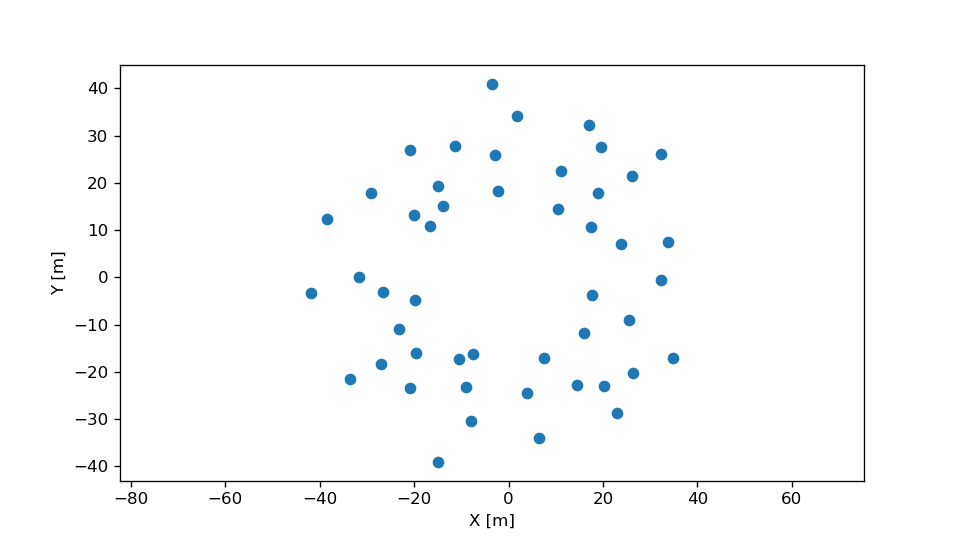

In [5]:
fig, ax = hdfig((1,1))
ax.scatter(ant_pos[:,0], ant_pos[:,1])  # FILL_IN make a scatter plot of the x- and y- coordinates
#for ant_id, pos in enumerate(ant_pos):  
#    ax.text(pos[0], pos[1], '%02d' % ant_id)
ax.set_xlabel('X [%s]' % ant_pos.unit)
ax.set_ylabel('Y [%s]' % ant_pos.unit)
ax.axis('equal')

**QUESTIONS**

1. Does the map you generated above match with the aerial photography on the lofarmap web site? If not: fix it.

2. What does the vertical position distribution look like? How large are the $z$ coordinates typically?

A: (sub) mm: very small

3. What is the approximate station diameter?

A: 80 m

Now proceed by extracting the lofar data you downloaded from the data repository according to the instructions in the Syllabus into a directory called `cs501-data`. The so-called "xst" or "cross-correlation statistics" files contain the output of the station correlator. Execute the following cell:

In [6]:
DATADIR = "./cs501-data/"
acm_file_names = os.listdir(DATADIR)
acm_file_names

['20201111_131137_mode_1_xst_sb370.dat',
 '20201111_140516_mode_1_xst_sb355.dat',
 '20201111_140316_mode_1_xst_sb315.dat',
 '20201111_130837_mode_1_xst_sb310.dat',
 '20201111_140331_mode_1_xst_sb320.dat',
 '20201111_130907_mode_1_xst_sb320.dat',
 '20201111_131322_mode_1_xst_sb405.dat',
 '20201111_130822_mode_1_xst_sb305.dat',
 '20201111_130807_mode_1_xst_sb300.dat',
 '20201111_131022_mode_1_xst_sb345.dat',
 '20201111_140446_mode_1_xst_sb345.dat',
 '20201111_130952_mode_1_xst_sb335.dat',
 '20201111_130707_mode_1_xst_sb280.dat',
 '20201111_130752_mode_1_xst_sb295.dat',
 '20201111_140631_mode_1_xst_sb380.dat',
 '20201111_131222_mode_1_xst_sb385.dat',
 '20201111_131252_mode_1_xst_sb395.dat',
 '20201111_130737_mode_1_xst_sb290.dat',
 '20201111_140801_mode_1_xst_sb410.dat',
 '20201111_130937_mode_1_xst_sb330.dat',
 '20201111_130722_mode_1_xst_sb285.dat',
 '20201111_131122_mode_1_xst_sb365.dat',
 '20201111_131307_mode_1_xst_sb400.dat',
 '20201111_140546_mode_1_xst_sb365.dat',
 '20201111_13103

The file names have a few components

- Date and time in UTC of the beginning of the first integration
- The receiver unit (RCU) mode (mode 1 means "the outer 48 Low Band Antennas of the station, with the possibility to observe between 10 and 90 MHz")
- The subband number

Lofar's ADC samples the data at 12 bits at a sample rate of 200 MHz.

**QUESTION**

1. What is the maximum band width that can be sampled at the Nyquist rate?

A: 100 MHz

To ensure the quasi-monochromatic assumption is reasonable, the station's processing boards ("RSP boards") split this maximum band width into 512 sub bands, where the first (sb000) has a frequency of 0 MHz.

Complete the following function to calculate the central frequency for a subband:

In [7]:
def subband_frequency(subband_number, clock_frequency=200*u.MHz):
    r'''
    Returns an astropy quantity containing the subband frequency.
    
    **Examples**
    
    >>> f = subband_frequency(128)
    >>> type(f)
    astropy.units.quantity.Quantity
    >>> print(f)
    25.0 MHz
    '''
    return (subband_number/512)*clock_frequency/2 # FILL_IN

#TEST CODE
assert subband_frequency(128) == 25.0*u.MHz

## XST .dat File contents

The files contain a 3D array of `np.complex128` numbers. In this case, for the LBA_OUTER configuration, the even receive units(RCUs) contain the "y-polarisation" data, and the odd ones the "x-polarisation" data. The following function can read such a file. The integration time was 1 second per "frame" or "time slot". The duration of the observations was typically 10 seconds.

In [8]:
def read_acm_cube(filename, num_rcus=96):
    r'''
    **Parameters**

    filename : string
        The file containing the array correlation matrix.

    num_rcus : int
        Number of receiver units (twice the number of antennas) used in the correlator.
        Default for Dutch stations is 96

    **Returns**

    A 3D cube of complex numbers, where the indices are [time slot, rcu, rcu].

    **Examples**

    >>> cube = read_acm_cube('test/DE602C/sb296/20120109_232258_xst.dat', 192)
    >>> cube.shape
    (4, 192, 192)
    '''
    data       = np.fromfile(filename, dtype = np.complex128)
    time_slots = len(data)//num_rcus//num_rcus
    return data.reshape((time_slots, num_rcus, num_rcus))


We will now read the data file containing the array correlation matrices ("visibilities") for subband 290. Note that these data are uncalibrated cross-correlations, straight from the processing boards at the LOFAR station.

**QUESTION**

1. What is the observing frequency for that sub band?

A: approximately 56.6406 MHz



In [9]:
subband_frequency(290) # FILL_IN using one of the functions defined earlier

<Quantity 56.640625 MHz>

In [10]:
acm_cube = read_acm_cube('cs501-data/20201111_140201_mode_1_xst_sb290.dat')  # FILL_IN
acm_cube.shape

(10, 96, 96)

**QUESTIONS**

1. What is the slowest varying (first) index into the array?

A: Time slot (and in this case: time because of the 1 second integration time)

The following two functions are used to inspect/view the array correlation matrices. Study them carefully before proceeding 

In [11]:
def plot_acm_frame(acm, ax):
    ax.imshow(np.log10(np.absolute(acm)))
    ax.set_xlabel('Col')
    ax.set_ylabel('Row')
    
def plot_raw_acm_cube(acm_cube):
    fig, ((tl,tr),(bl, br)) = hdfig((2,2))
    fig.subplots_adjust(hspace=0.5)
    tl.set_title('Median ACM')
    plot_acm_frame(np.median(acm_cube,axis=0), ax=tl)

    tr.set_title('Mean ACM')
    tr.plot(np.absolute(acm_cube).reshape((acm_cube.shape[0],-1)).mean(axis=1))
    tr.set_xlabel('Time slot')

    bl.set_title('Mean auto-correlation')
    bl.plot(np.absolute(np.diag(acm_cube.mean(axis=0))))
    bl.set_xlabel('RCU')

    br.set_title('Stddev ACM')
    br.plot(np.absolute(acm_cube).reshape((acm_cube.shape[0],-1)).std(axis=1))
    br.set_xlabel('Time slot')
    


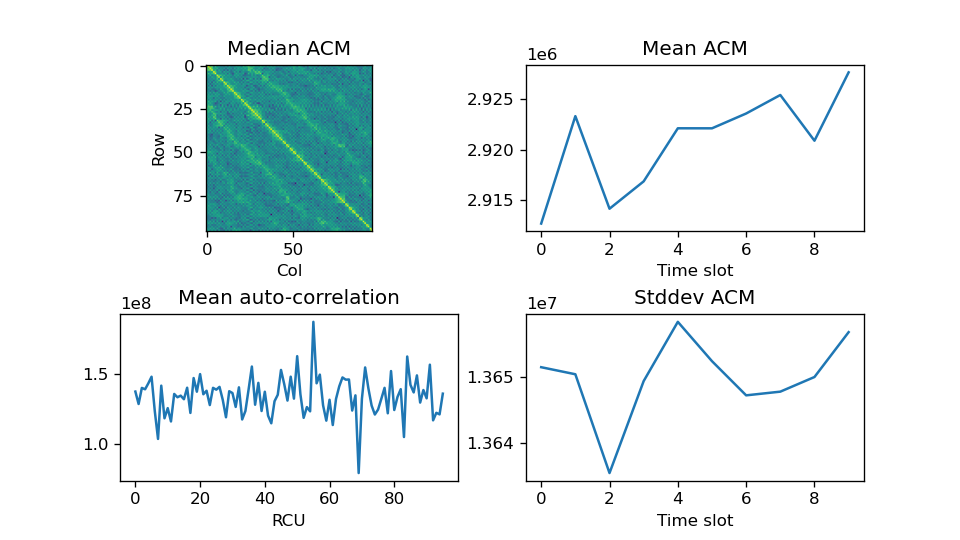

In [12]:
plot_raw_acm_cube(acm_cube)

Note the banded structure of the median ACM. We'll get back to that shortly. Are there any time slots or RCUs that stand out significantly from the others? If so, take note of that and make additional plots of the specific time slots, or other sub-sets of data involving the specific RCU.

Now repeat these plots for some of the other sub bands.

**QUESTIONS**

1. In some sub bands you'll see (some) time slots with significantly higher standard deviation and mean ACM. What could cause that?

A: radio interference from (likely) non-natural sources.

2. Inspect the ACM in one time frame that exhibits strong mean amplitude or standard deviation. Describe the ACM structure.

A: The ACM looks much more like a checkerboard. Contrast between auto-correlation and cross-correlations is weaker.


## IMAGER

Now we'll write the functions that add the visibilities in an ACM coherently for a position $(l, m)$ on the sky.

That is done using the van-Cittert-Zernike theorem.

**QUESTION**

1. Write down the equation that converts complex cross correlation products (visibilities) per baseline into an image of the sky, under the condition that the $w$ coordinate of the baselines is negligible (verify that this is the case, given the observing wavelength and the antenna coordinates in the plane of the station). Assume that $u$ and $v$ are given in meters, and that the observing frequency is provided.

A.: Use equation 3.198
\begin{equation}
\frac{I(l, m)}{\sqrt{1-l^2-m^2}} = \iint_{-\infty}^{+\infty}  v(u, v) \mathrm{e}^{2\pi\mathrm{i}\nu(ul+vm)/c}\hspace{3ex} \mathrm{d}u\ \mathrm{d}v
\end{equation}


We are working towards a function that computes the modified brightness-distribution for a single pixel. Because we currently know the visibilities and the observing frequency (as well as the speed of light), and $l$ and $m$ are provided as parameters to the function, we first write a function that computes the $u$ and $v$ coordinates of all baselines between antennas within the station in meters. We'll use the convention that the $uv$ vector points from antenna 1 towards antenna 2.

In [13]:
def compute_uv_coordinates(ant_pos, dtype=np.float32):
    r'''
    Return an array of all uv-coordinates. The array has a shape of
    (num_ant, num_ant, 2), and should be of type `dtype`, and unit 
    `astropy.units.m`
    '''
    num_ant = len(ant_pos)
    u_ant = ant_pos[:,0]   # FILL_IN
    v_ant = ant_pos[:,1]   # FILL_IN
    result = np.zeros((num_ant, num_ant, 2), dtype=dtype)*u.m
    for ant1 in range(num_ant):
        for ant2 in range(num_ant):
            #result[ant1, ant2, 0] = u_ant[ant2] - u_ant[ant1]   # FILL_IN
            #result[ant1, ant2, 1] = v_ant[ant2] - v_ant[ant1]   # FILL_IN
            result[ant1, ant2] = ant_pos[ant2,:2] - ant_pos[ant1,:2]  #FILL_IN (alternative implementation)
    return result

# TEST CODE
uv             = compute_uv_coordinates(ant_pos)
anti_symmetric = (uv == -uv.transpose((1,0,2))).all()
point_check    = (uv[19,7] - np.array([6.4685407, -12.008927])*u.m) < 1*u.um
if anti_symmetric and point_check.all():
    print('CORRECT!')
else:
    print('Not yet there...')

CORRECT!


Time to plot the $uv$-plane. Left: every visibility at its ($u$, $v$) coordinates. Right: the $uv$ distance of each antenna pair.

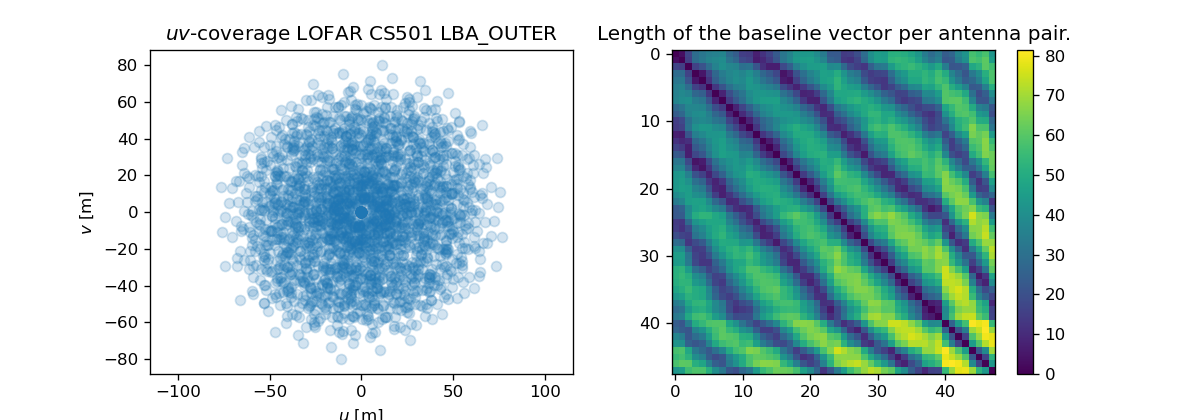

In [14]:
fig, (ax_cov, ax_mat) = hdfig((1,2),figsize=(10,3.5))
uv_reshaped = uv.reshape((-1, 2))
ax_cov.set_title('$uv$-coverage LOFAR CS501 LBA_OUTER')
ax_cov.set_xlabel('$u$ [%s]' % uv.unit)
ax_cov.set_ylabel('$v$ [%s]' % uv.unit)
ax_cov.scatter(uv_reshaped[:,0], uv_reshaped[:,1], alpha=0.2)
ax_cov.axis('equal')

ax_mat.set_title('Length of the baseline vector per antenna pair.')
mp_mat = ax_mat.imshow(np.linalg.norm(uv, axis=2).value)
cb = fig.colorbar(mp_mat)

**QUESTION**

1. Compare to the ACM. Compare and explain what you see.

A: The bands showing short baselines in here, coincide with the light bands indicating high visibility power in the ACM. Short baselines means large scales on the sky, so apparently there are / (is a) very large, bright source somehwhere out there.

As the code you are about to develop is somewhat time critical, it is important to understand that 32-bit floating point numbers (`np.float32` and `np.complex64`) can be manipulated MUCH faster than their 64-bit equivalents (`np.float`, `np.float64`, `np.complex128`). Furthermore, any units conversion/handling should happen at the beginning of time-critical functions, not in the inner compute loops. This is especially important for the actual brightness-computing functions.

In [15]:
from scipy import constants as const

def pixel_brightness_snail(acm_single_pol, l, m, ant_pos, frequency):
    a = acm_single_pol
    u_ant = ant_pos[:,0]
    v_ant = ant_pos[:,1]
    f = frequency.to(u.Hz)
    brightness = 0.0
    num_vis = 0
    for ant1 in range(acm_single_pol.shape[0]):
        for ant2 in range(acm_single_pol.shape[0]):
            if ant1 != ant2: # only add cross-correltions, no auto-correlations
                uu = u_ant[ant2] - u_ant[ant1]
                vv = v_ant[ant2] - v_ant[ant1]
                brightness += (a[ant1, ant2]*np.exp(2j*np.pi*f*(uu.to(u.m)*l.to(u.rad) + vv.to(u.m)*m.to(u.rad))/(const.c*u.m/u.s))).real
                num_vis += 1
    return brightness/num_vis

def pixel_brightness_faster(acm_single_pol, l, m, uv, frequency):
    a = acm_single_pol.astype(np.complex64)
    f = frequency.to(u.Hz).value
    uv_l = uv.to(u.m).value
    uv_l *= f/const.c
    brightness = 0.0
    num_vis = 0
    ll = l.to(u.rad).value.astype(np.float32)
    mm = m.to(u.rad).value.astype(np.float32)
    for a1 in range(acm_single_pol.shape[0]):
        for a2 in range(acm_single_pol.shape[0]):
            if a1 != a2: # only add cross-correltions, no auto-correlations
                brightness += (a[a1, a2]*np.exp(2j*np.pi*(uv_l[a1,a2,0]*ll + uv_l[a1,a2,1]*mm))).real
                num_vis += 1
    return brightness/num_vis


def pixel_brightness_lightning(acm_single_pol, l, m, uv, frequency):
    a = acm_single_pol.astype(np.complex64)
    n = a.shape[0]     # number of antennas
    f = frequency.to(u.Hz).value
    uv_l = uv.to(u.m).value.astype(np.float32)
    uv_l *= f/const.c
    ll = l.to(u.rad).value
    mm = m.to(u.rad).value
    mask = np.ones((n, n), dtype=np.float32)
    mask -= np.diag(np.ones(n, dtype=np.float32)) # remove auto-correlations
    num_vis = mask.sum()
    brightness = (a*mask*np.exp(2j*np.pi*(uv_l[...,0]*ll + uv_l[...,1]*mm))).real.sum()
    return brightness/num_vis   

## Selecting data and setting parameters

1. Given the antenna configuration and/or the $uv$ coverage, calculate how many pixels are required across the full sky's (projected) diameter to over sample the FHWM resolution of the instrument by at least a factor of 2.5. Note that an all-sky image in SIN projection is 2~rad across.

A: 75 or more

In [16]:
over_sampling = 2.5   # EXAMPLE CALCULATION
pixel_separation = (const.c*u.m/u.s/subband_frequency(290)/(80*u.m)).to(u.dimensionless_unscaled)/over_sampling
num_pix = 2.0/pixel_separation
num_pix

<Quantity 75.57311532>

Although in FFT imaging, one often chooses a number of pixels that is a power of two, and chooses the phase centre to be at pixel n//2, for this all-sky imaging, we'll be using an odd number of pixels, such that the horizon is nicely symmetric.

In [17]:
num_pix = 75    # FILL_IN

Now we need to select the array correlation matrices of the xx and yy correlations, to make separate images and combine them afterward.

In [18]:
acm_xx = acm_cube[:,1::2,1::2].mean(axis=0).astype(np.complex64) # FILL_IN
acm_yy = acm_cube[:,0::2,0::2].mean(axis=0).astype(np.complex64) # FILL_IN
acm_xx.shape, acm_xx.dtype

((48, 48), dtype('complex64'))

In [19]:
from tqdm.notebook import tqdm  # progress bar!

def make_image(acm, num_pix, uv, frequency, l_range=(1.0, -1.0), m_range=(-1.0, 1.0)):
    r'''
    The returned image should have its origin pixel (0,0) in bottom-left corner (south-east).
    '''
    img = np.zeros((num_pix, num_pix), dtype=np.float32)
    l_coor = np.linspace(*l_range, num_pix)*u.rad
    m_coor = np.linspace(*m_range, num_pix)*u.rad

    for m_ix, m in enumerate(tqdm(m_coor)):
        for l_ix, l in enumerate(l_coor):
            img[m_ix, l_ix] = pixel_brightness_lightning(acm, l, m, uv, frequency)
    pixel_sep = m_coor[1]-m_coor[0]
    half = pixel_sep.to(u.rad).value/2.0
    img_extent =(l_coor[0].to(u.rad).value+half, m_coor[0].to(u.rad).value-half, 
                 l_coor[-1].to(u.rad).value-half, m_coor[-1].to(u.rad).value+half)    
    return img, img_extent

In [20]:
frequency = subband_frequency(290)                  # FILL_IN
img_xx, extent = make_image(acm_xx, num_pix, uv, frequency) # FILL_IN
img_yy, _      = make_image(acm_yy, num_pix, uv, frequency) # FILL_IN
img_I = img_xx+img_yy # FILL_IN Stokes I image

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

np.float32(1834003.4)

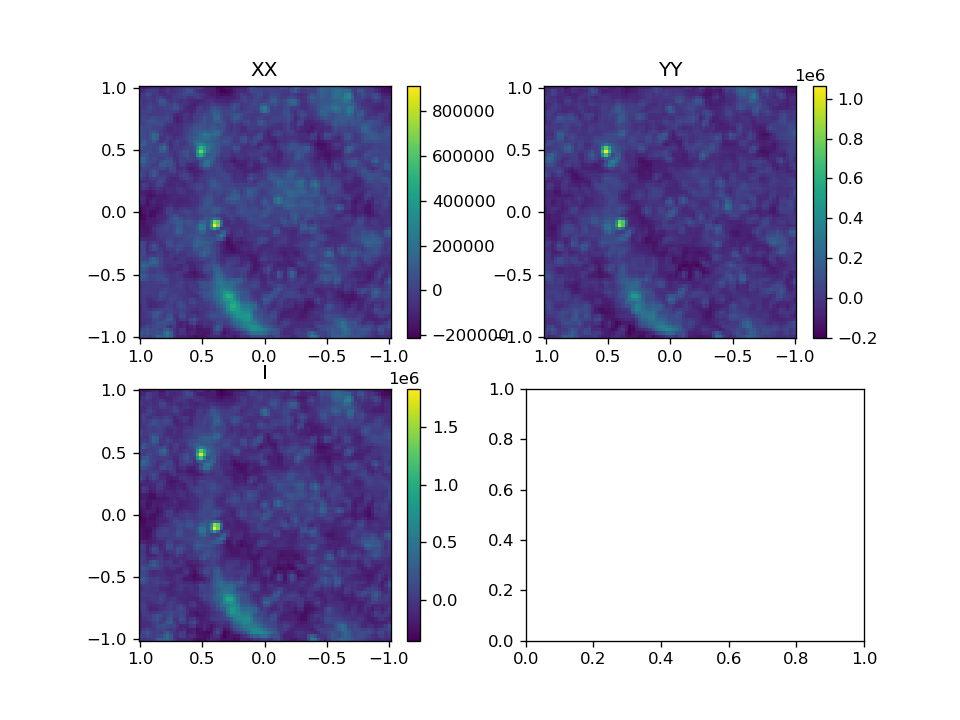

In [21]:
fig, ((ax_xx, ax_yy), (ax_i, _)) = hdfig((2,2), figsize=(8,6))
ax_xx.set_title('XX')
mp_xx = ax_xx.imshow(img_xx, origin='lower', extent=extent)
ax_yy.set_title('YY')
mp_yy = ax_yy.imshow(img_yy, origin='lower', extent=extent)
ax_i.set_title('I')
mp_i = ax_i.imshow(img_I, origin='lower', extent=extent)

fig.colorbar(mp_xx, ax=ax_xx)
fig.colorbar(mp_yy, ax=ax_yy)
fig.colorbar(mp_i, ax=ax_i)

img_I.max()

**QUESTIONS**

1. Where are North, South, East and West?

A: Top, Bottom, Left, Right

2. Where are POSITIVE l and m?

A: East (left) and North (top)

3. Where is the horizon?

A: it is the inscribed circle of this square image.

4. Identify the bright compact objects at the top-left and  centre-left, as well as the curved elongated structure running from the bottom-centre towards the compact objects.

A: top-left: Cassiopeia A, centre-left: Cygnus A, elongated structure: Milky way.

5. Why are the relative brightnesses of the sources so different between the XX and YY maps?

A: The X and Y dipoles are orthogonal and each have a relatively elliptical beam shape. Of course, intrinsic source polarization could also cause differences, however, at such f=low frequencies, very few sources are significantly polarized, and polarized sources are unlikely to show systematic behaviour at scales in the sky comparable to the antenna beam pattern.

6. We have added the xx and yy *images*. Would it also have been possible to add the xx and yy ACMs before imaging? Why or why not?

A: Yes, because the Fourier transform is a linear operator. It would actually save almost a factor 2 in computation!

## PSF

The images above look messy because of the limited sampling of the $uv$-space. Effectively, the Fourier transform of the sky is multiplied by a weight function that's 1 where there's a visibility, and 0 elsewhere. This multiplication in $uv$-space lead to a convolution with a point spread function (PSF) in the image.

Calculate and plot the PSF across a range of l=(1,-1), m=(-1,1).

In [22]:
psf, psf_extent = make_image(np.ones_like(acm_xx), num_pix, uv, frequency) # FILL_IN

  0%|          | 0/75 [00:00<?, ?it/s]

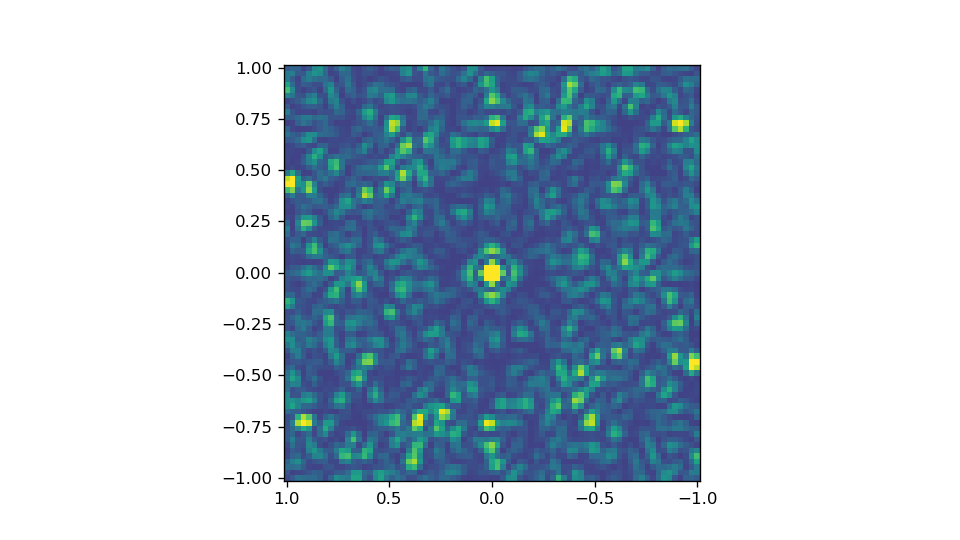

In [23]:
fig, ax = hdfig((1,1))
ax.imshow(psf, origin='lower', extent=psf_extent, vmin=-0.05, vmax=0.1) # FILL_IN

## CLEAN

Knowing the PSF, and having read Hogbom's paper, try to implement the CLEAN algorithm yourself. (Entirely voluntary, but highly instructive)

In [ ]:
# FILL_IN